In [ ]:
# Initialize Otter
import otter
grader = otter.Notebook("Linear systems - Poisson equation.ipynb")

# Matrix Analysis 2024 - EE312

## Week 6 - Discrete Poisson equation 
[LTS2](https://lts2.epfl.ch)

### Objectives
Apply your knowledge about linear systems to Poisson equation resolution.

## Poisson equation
Let $u,v \in \mathbb{R}^n$  represent a physical quantity $f$ and $g: \mathbb{R} \mapsto \mathbb{R}$ sampled at $n$ equi-spaced locations $x_i$, i.e $u_i = f(x_i)$, $v_i = g(x_i)$. 

Let us assume that the underlying continuous object satisfies the Poisson equation: $\frac{d^2}{dx^2} f (x)= g(x)$ with constraints $f(x_j) = y_j$ for a subset of $m$ locations $j \in \{i_1, \ldots i_m \}$. 

We will assume that **all the $i_k$ are distinct**.

This equation governs a number of physical principles, e.g. gravity, fluid mechanics and electrostatics. In the latter we have $\Delta \varphi = -\frac{\rho}{\varepsilon}$, where $\Delta$ is the Laplacian operator $(\frac{d^2}{dx^2} + \frac{d^2}{dy^2} + \frac{d^2}{dz^2})$, $\varphi$ is the electric potential, $\rho$ the density of electric charges and $\varepsilon$ the electric permittivity.

---

#### For the sake of simplicity, we will only consider the 1D case.

In [4]:
import numpy as np
import matplotlib.pyplot as plt

<!-- BEGIN QUESTION -->

1. Write down a matrix equation for the discrete version of $\frac{d^2}{dx^2} f (x)= g(x)$, using the finite-difference approximation of the derivative $\frac{d^2}{dx^2} f  = f(x_{k+1}) - 2f(x_k) +f(x_{k-1})$. For the boundary conditions we will make the assumption that $x_{-1}=x_0$ and $x_{n-1}=x_n$ (also referred to as Dirichlet boundary conditions)

What is the rank of the corresponding matrix $D$ ? 

_Type your answer here, replacing this text._

If we use zero-padding instead of the constant extension this equations satisfy $Du = v$ with 
$D=\begin{pmatrix}
-2 & 1 & 0  & 0& ... & 0\\ 
1 & -2 & 1 & 0 &... &0\\
0 & 1 & -2 & 1 &... &0\\
& & & ... & & \\
0 & 0 & ... & 1 & -2 & 1\\
0 & 0 & ... & 0 & 1 & -2\\
\end{pmatrix}$

This is the laplacian matrix. 

$\mbox{rank }D = n$.

If we use a Dirichlet boundary condition, i.e. constant extension, we have $u_{-1}=u_0$ and $u_n = u_{n+1}$, therefore

$D=\begin{pmatrix}
-1 & 1 & 0  & 0& ... & 0\\ 
1 & -2 & 1 & 0 &... &0\\
0 & 1 & -2 & 1 &... &0\\
& & & ... & & \\
0 & 0 & ... & 1 & -2 & 1\\
0 & 0 & ... & 0 & 1 & -1\\
\end{pmatrix}$

In this case the rank is $n-1$ since the sum of rows/columns is 0 and if we remove one row/column they become linearly independent.

<!-- END QUESTION -->

<Your answers here>

2. Implement a function that creates the $D$ matrix (also called Laplacian). The [diag](https://numpy.org/doc/stable/reference/generated/numpy.diag.html) function in numpy might be useful.

In [3]:
def lapl_matrix(N):
    # BEGIN SOLUTION
    O = np.ones(N-1)
    D = -2*np.eye(N) + np.diag(O, -1) + np.diag(O, 1)
    D[0,0] = -1
    D[N-1, N-1] = -1
    return D
    # END SOLUTION

In [ ]:
grader.check("q2")

<!-- BEGIN QUESTION -->

3. Write down a matrix equation for the discrete version of $f(x_j) = y_j$. What is the rank of the corresponding matrix $B$ ?

_Type your answer here, replacing this text._

This operation can be represented by a matrix $B\in\mathbb{R}^{n\times m}$ where the coefficients $b_{kp} = \delta_{ki_p}$.
The rank of this matrix is $m$, under the assumption that all $i_k$ are distinct, since every row has a single non-zero value.

Using this matrix we can rewrite the condition $f(x_j) = y_j$ as $Bu=\begin{pmatrix}y_0\\ \vdots \\y_{m-1}\end{pmatrix}$

<!-- END QUESTION -->

4. Implement a function that creates matrix $B$

In [20]:
def b_matrix(N, idx_list): # idx_list is a list of valid indices, e.g. N=5, idx_list=[1,3]
    # BEGIN SOLUTION
    m = len(idx_list)
    if m<1:
        raise ValueError("Supply at least one index")
    if not np.all(np.array(idx_list)<N):
        raise ValueError("Invalid list of indices supplied")
    if not np.all(np.array(idx_list)>=0):
        raise ValueError("Negative indices supplied")
    if N<1 or m >= N:
        raise ValueError("Invalid dimensions")
        
    B = np.zeros((m, N))
    for p in zip(range(m), idx_list):
        B[p[0], p[1]] = 1.
    return B
    # END SOLUTION

In [ ]:
grader.check("q4")

<!-- BEGIN QUESTION -->

3. Write down a matrix equation for the full problem (Hint: Consider the matrix $C=\begin{pmatrix}D\\B\end{pmatrix}$). Discuss the rank of the matrix and deduce a way to numerically solve the linear system. Implement a function that returns matrix $C$.

_Type your answer here, replacing this text._

Let us use the matrix $C=\begin{pmatrix}D\\B\end{pmatrix}$.

The following holds $Cu = z$, with $z=\begin{pmatrix}v_0\\v_1\\...\\v_{n-1}\\y_0\\y_1\\...\\y_{m-1}\end{pmatrix}$.

Let us suppose there exist non zero $\alpha_i$ s.t.

$\sum_{i=0}^{n-1} \alpha_i C_i = 0$, where $C_i$ is the $i$-th column of $C$.

Looking at the bottom part of $C$, we must have $\alpha_i=0, i\in\{i_1,...,i_m\}$. The $\alpha_i$ are can only be non-zero when the lower part of the vector only has 0s. Given a subset of columns of $D$ will have at least one row with a single non zero coefficient  making the associated $\alpha_i = 0$, which then propagates to the rest (since columns have disjoint support), the rank of $C$ is $n$.

We can get the solution using $C^+$.

In [25]:
def c_matrix(D, B):
    # BEGIN SOLUTION
    sd = D.shape
    sb = B. shape
    C = np.zeros((sd[0]+sb[0], sd[1]))
    C[:sd[0], :] = D
    C[sd[0]:, :] = B
    return C
    # END SOLUTION

In [ ]:
grader.check("q4")

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

5. What explicit formula can you use to compute the pseudo-inverse of $C$ (justify)?

_Type your answer here, replacing this text._

The rank of $C$ is $n$, the columns of $C$ are independent, therefore the matrix is 1-1. We can use the left pseudo inverse

$C^+=(C^TC)^{-1}C^T$

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

6. Implement a function that return the solution of the problem. You can either use the formula above (you may then use the [linalg.inv](https://numpy.org/doc/stable/reference/generated/numpy.linalg.inv.html) or compute the pseudo-inverse using [linalg.pinv](https://numpy.org/doc/stable/reference/generated/numpy.linalg.pinv.html).

In [23]:
# v is a vector of size N
# u is a vector of size len(idx_list)
def solve_poisson(N, v, idx_list, u): 
    # BEGIN SOLUTION
    D = lapl_matrix(N)
    B = b_matrix(N, idx_list)
    C = c_matrix(D, B)
    z = np.zeros(C.shape[0])
    z[:N] = v
    for p in zip(range(len(u)), u):
        z[N+p[0]] = p[1]
    Cinv = np.linalg.pinv(C)
    #or 
    # Cinv = np.linalg.inv(C.T@C)@C.T
    return Cinv@z
    # END SOLUTION

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

7. Let us now consider the solutions of the particular case $g(x) = 0, \forall x\in\mathbb{R}$. What are the analytical solutions that would solve Poisson equation ?

_Type your answer here, replacing this text._

The analytical solutions are polynomial of degree 1 (s.t. their second derivative is 0), i.e. linear functions, i.e. $f(x)=ax+b$.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Let us verify that our implementation of the solution works with a small example. Fill the values for $u$ s.t. they belong to the solution space.

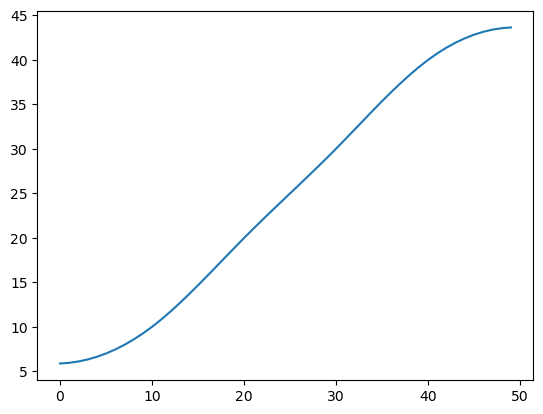

In [26]:
N = 50
v = np.zeros(N)
idx_list = [10, 20, 30, 40]
u = [10, 20, 30, 40] # SOLUTION
sol = solve_poisson(N, v, idx_list, u)
plt.plot(sol) # plot the result

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

9. Are the results conform to what we expected ? What happens near the boundaries ?

_Type your answer here, replacing this text._

We obtain a solution that is linear except near it boundaries. The aspect of the solution near the boundaries is due to the Dirichlet conditions we impose (i.e. solution should be constant outside the interval displayed). The values we had set as constraints are matched closely.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

10. Let us use a step function for $f$ and try to solve the system

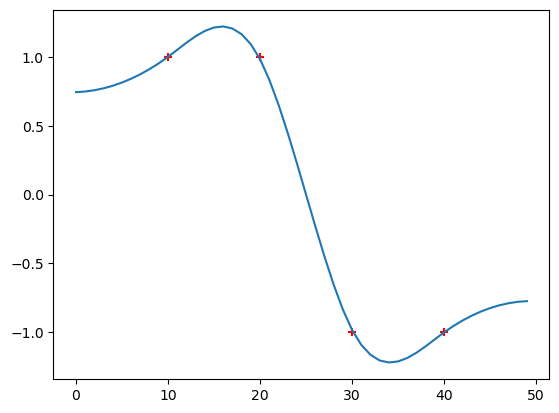

In [40]:
idx_list = [10, 20, 30, 40]
u2 = [1, 1, -1, -1]
sol2 = solve_poisson(N, v, idx_list, u2)
plt.scatter(idx_list, u2, marker='+', color='r')
plt.plot(sol2)

What do you observe and what is the reason for that ? 

_Type your answer here, replacing this text._

If we deliberately choose $f$ to be outside of the solution space, we obtain a poor approximation and our constraints are not met (which is expected).

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

11. Let us now consider the application of the Poisson equation to electrostatic. Knowing a distribution of electric charges, we can solve it to compute the electric potential. The distribution of electric charges will be very simple, consisting of two punctual charges

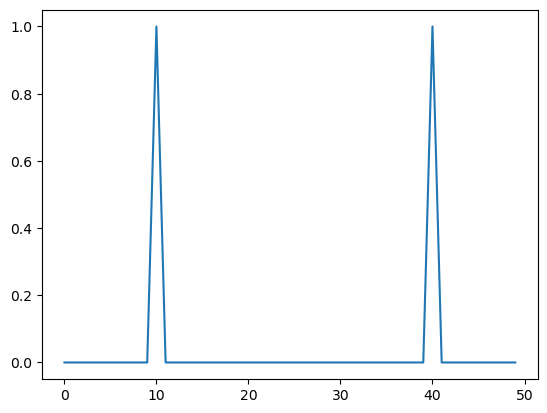

In [33]:
N = 50
v3 = np.zeros(N)
v3[10] = 1
v3[40] = 1
plt.plot(v3)

- What are the analytical solutions for this problem ? (remember the discrete derivative of a step function is a Dirac function, i.e. 0 everywhere except at one point where it is 1). 
- Plot the analytical solution
- Compute and plot the numerical solution
- What do you observe ? 

_Type your answer here, replacing this text._

The analytical solution is a piecewise linear solution. Integrating once the 2-peaked will lead to picewise constant function, and piecewise linear if we integrate twice. 

If you use the constraints we impose for the numerical example you can compute the theoretical solution of the problem satisfying the constraints (that was not asked in the question so the above answer was sufficient). If you impose the solution to be constant between 10 and 40, it means its derivative is 0 in this interval. Below 10 the derivative is then -1 and above 40 the derivative is 1. 

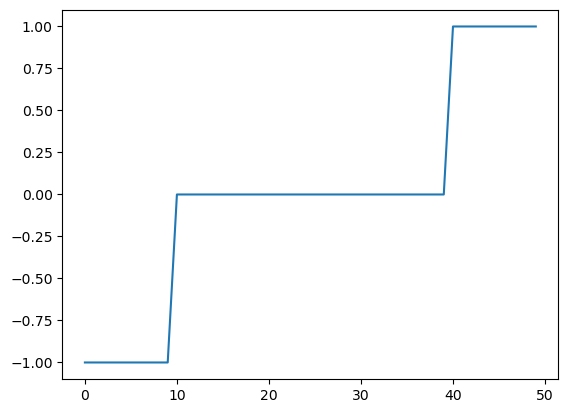

In [34]:
# BEGIN SOLUTION
d=np.zeros(50)
d[:10]=-1
d[40:]=1
plt.plot(d)
# END SOLUTION

If we solve $-x+a = 1$ for $x=10$ and $x+b=1$ for $x = 40$, the analytical solution that satisfies the constraint is:
- $f(x) = -x+11, x<10$
- $f(x) = 1, 10\le x\le 40$
- $f(x) = x - 39, x>40$

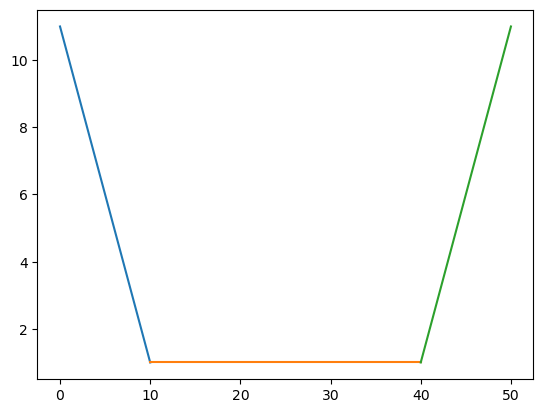

In [35]:
# Plot analytical solution
# BEGIN SOLUTION
x1 = np.arange(0, 11)
x2 = np.arange(10, 41)
x3 = np.arange(40, 51)
plt.plot(x1, -x1+11)
plt.plot(x2, np.ones(x2.shape))
plt.plot(x3, x3-39)
# END SOLUTION

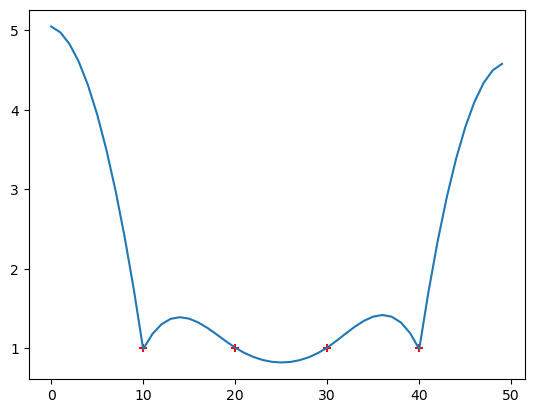

In [39]:
idx_list = [10, 20, 30, 40]
u3 = [1, 1, 1, 1]
sol3 = solve_poisson(N, v3, idx_list, u3)
plt.scatter(idx_list, u3, marker='+', color='r')
plt.plot(sol3)

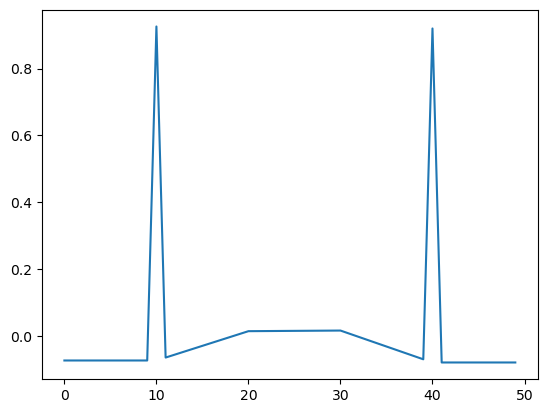

In [37]:
# check the 2nd derivative of the solution computed
plt.plot(lapl_matrix(50)@sol3[:50]) # SOLUTION

We can see the solution computed is acceptable as its second derivative matches the original distribution (it is not fully constant between the peaks but close enough). The Dirichlet boundary conditions are once again interfering at $x=0$ and $x=50$, and the derivative not being continuous also has an impact on the constant part.

<!-- END QUESTION -->

